<a href="https://colab.research.google.com/github/radical-p/NeuralLog/blob/main/Transformer_based_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug  7 07:36:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install -q tf-models-official

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.7.0 requires PyYAML>=5.4.1, but you have pyyaml 5.3.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [3]:
pip install numpy --upgrade

  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.7.0 requires PyYAML>=5.4.1, but you have pyyaml 5.3.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.25.2 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pickle

In [6]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from official.nlp import optimization

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### only run this cell if you want to train the model by your self

In [8]:
#from sklearn.utils import shuffle
from sklearn.metrics import classification_report

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# II. Transformer

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [11]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
class PositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = positional_encoding(max_len,
                                                embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        return x

In [13]:
embed_dim = 768  # Embedding size for each token
num_heads = 12  # Number of attention heads
ff_dim = 2048  # Hidden layer size in feed forward network inside transformer
max_len = 75
num_layers = 1

In [14]:
def transformer_classifer(input_size, loss_object, optimizer, dropout=0.1):
    inputs = layers.Input(shape=(max_len, embed_dim))
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    embedding_layer = PositionEmbedding(100, 2000, embed_dim)
    x = embedding_layer(inputs)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss_object, metrics=['accuracy'],
                  optimizer=optimizer)
    return model

# Training/Testing

In [15]:
class BatchGenerator(Sequence):

    def __init__(self, X, Y, batch_size):
        self.X, self.Y = X, Y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        # print(self.batch_size)
        dummy = np.zeros(shape=(embed_dim,))
        x = self.X[idx * self.batch_size:min((idx + 1) * self.batch_size, len(self.X))]
        X = np.zeros((len(x), max_len, embed_dim))
        Y = np.zeros((len(x), 2))
        item_count = 0
        for i in range(idx * self.batch_size, min((idx + 1) * self.batch_size, len(self.X))):
            x = self.X[i]
            if len(x) > max_len:
                x = x[-max_len:]
            x = np.pad(np.array(x), pad_width=((max_len - len(x), 0), (0, 0)), mode='constant',
                       constant_values=0)
            X[item_count] = np.reshape(x, [max_len, embed_dim])
            Y[item_count] = self.Y[i]
            item_count += 1
        return X[:], Y[:, 0]

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [17]:
def train_generator(training_generator, validate_generator, num_train_samples, num_val_samples, batch_size,
                      epoch_num, model_name=None):

    optim = Adam()
    epochs = epoch_num
    steps_per_epoch = num_train_samples
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-4
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    model = transformer_classifer(768, loss_object, optimizer)

    # model.load_weights("hdfs_transformer.hdf5")

    print(model.summary())

    # checkpoint
    filepath = model_name
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max',
                                 save_weights_only=True)
    early_stop = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )
    callbacks_list = [checkpoint, early_stop]

    # class_weight = {0: 245., 1: 1.}

    model.fit_generator(generator=training_generator,
                        steps_per_epoch=int(num_train_samples / batch_size),
                        epochs=epoch_num,
                        verbose=1,
                        validation_data=validate_generator,
                        validation_steps=int(num_val_samples / batch_size),
                        workers=16,
                        max_queue_size=32,
                        callbacks=callbacks_list,
                        shuffle=True
                        # class_weight=class_weight
                        )
    return model

In [18]:
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_confusion_matrix(actual, predicted):
  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])

  cm_display.plot()
  plt.show()

  return


def train(X, Y, epoch_num, batch_size, tx, ty, model_file=None):
    X, Y = shuffle(X, Y)
    n_samples = len(X)
    train_x, train_y = X[:int(n_samples * 90 / 100)], Y[:int(n_samples * 90 / 100)]
    val_x, val_y = X[int(n_samples * 90 / 100):], Y[int(n_samples * 90 / 100):]

    training_generator, num_train_samples = BatchGenerator(train_x, train_y, batch_size), len(train_x)
    validate_generator, num_val_samples = BatchGenerator(val_x, val_y, batch_size), len(val_x)

    print("Number of training samples: {0} - Number of validating samples: {1}".format(num_train_samples,
                                                                                       num_val_samples))

    model = train_generator(training_generator, validate_generator, num_train_samples, num_val_samples, batch_size,
                              epoch_num, model_name=model_file)
    test_model(model, tx, ty, batch_size)
    return model


def test_model(model, x, y, batch_size):
    #x, y = shuffle(x, y)
    x, y = x[: len(x) // batch_size * batch_size], y[: len(y) // batch_size * batch_size]
    test_loader = BatchGenerator(x, y, batch_size)
    prediction = model.predict_generator(test_loader, steps=(len(x) // batch_size), workers=16, max_queue_size=32,
                                         verbose=1)
    prediction = np.argmax(prediction, axis=1)
    y = y[:len(prediction)]

    report = classification_report(np.array(y), prediction)
    print(report)

    plot_confusion_matrix(np.array(y), prediction)
    return prediction

In [19]:
from collections import Counter

In [20]:
with open("/content/drive/MyDrive/neural-train.pkl", mode="rb") as f:
    (x_tr, y_tr) = pickle.load(f)
#x_tr, y_tr = shuffle(x_tr, y_tr)
print(Counter(y_tr))
with open("/content/drive/MyDrive/neural-test.pkl", mode="rb") as f:
    (x_te, y_te) = pickle.load(f)
print(Counter(y_te))
print("Data loaded")

Counter({0: 446559, 1: 13489})
Counter({0: 111664, 1: 3349})
Data loaded


# Train Model yourself

In [ ]:
model = train(x_tr, y_tr, 1, 32, x_te, y_te, "hdfs_transformer.hdf5")

Number of training samples: 414043 - Number of validating samples: 46005
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 768)]         0         
                                                                 
 position_embedding (Positi  (None, 75, 768)           0         
 onEmbedding)                                                    
                                                                 
 transformer_block (Transfo  (None, 75, 768)           31491584  
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 768)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 768)              

<ipython-input-16-e829109666c2>:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


12938/12938 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9909
Epoch 1: val_accuracy improved from -inf to 0.99893, saving model to hdfs_transformer.hdf5
12938/12938 [==============================] - 1951s 150ms/step - loss: 0.0343 - accuracy: 0.9909 - val_loss: 0.0058 - val_accuracy: 0.9989


<ipython-input-17-ed8011676196>:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test_loader, steps=(len(x) // batch_size), workers=16, max_queue_size=32,


3594/3594 [==============================] - 213s 59ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111659
           1       0.97      0.99      0.98      3349

    accuracy                           1.00    115008
   macro avg       0.99      0.99      0.99    115008
weighted avg       1.00      1.00      1.00    115008



# Pre Trained Model

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = Adam()
pre_model = transformer_classifer(768, loss_object, optimizer)
pre_model.load_weights("/content/drive/MyDrive/hdfs_transformer.hdf5")

<ipython-input-18-f706a94a752a>:37: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test_loader, steps=(len(x) // batch_size), workers=16, max_queue_size=32,


14376/14376 [==============================] - 868s 60ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446543
           1       1.00      1.00      1.00     13489

    accuracy                           1.00    460032
   macro avg       1.00      1.00      1.00    460032
weighted avg       1.00      1.00      1.00    460032



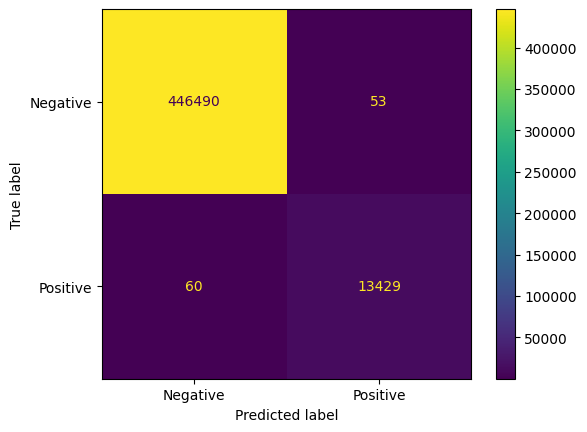

[0 0 0 ... 0 0 0]


In [22]:
pred = test_model(pre_model, x_tr, y_tr, 32)
print(pred)

# Comprehend output of Model

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.7.0 requires PyYAML>=5.4.1, but you have pyyaml 5.3.1 which is incompatible.


In [ ]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
explainer = shap.explainers.Permutation(model, max_evals = 1854721)
shap_values = explainer(np.array(x_tr[0]))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

TypeError: ignored

In [ ]:
np.array(x_tr[0]).shape

(20, 768)